## LOWESS Non-Parameteric Regression

### With Bootstrapped Uncertainty

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [3]:
url = "https://web.stanford.edu/~hastie/CASI_files/DATA/kidney.txt"
df = pd.read_csv(url, header=0, sep=' ')
df.head(4)

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30


In [4]:
n = df.shape[0]
x = df.age.values
y = df.tot.values

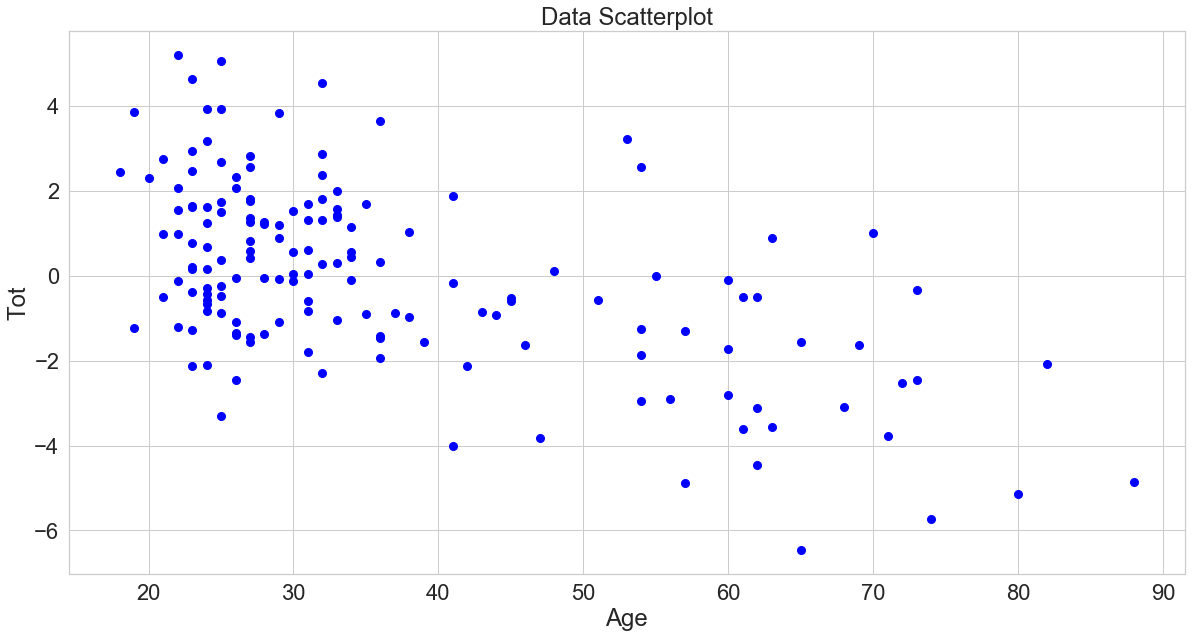

In [5]:
plt.plot(x, y, 'o', c='blue', ms=8)
plt.xlabel('Age')
plt.ylabel('Tot')
plt.title('Data Scatterplot')
plt.show()

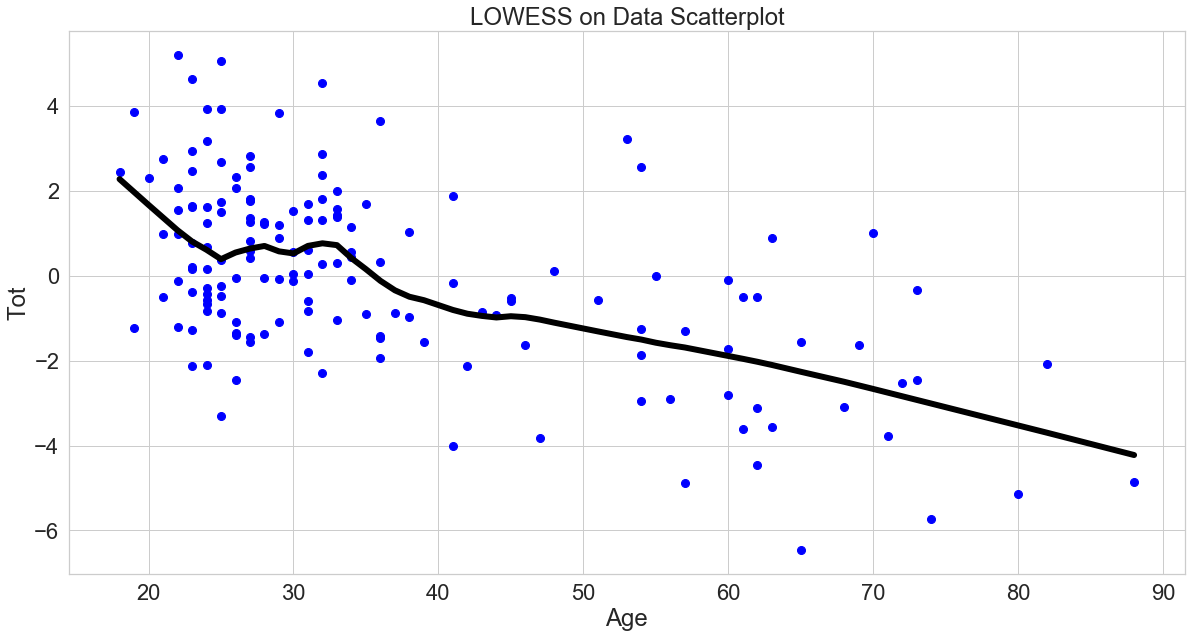

In [6]:
ypred = sm.nonparametric.lowess(y, x, frac=1/4., return_sorted=False)

plt.plot(x, y, 'o', c='blue', ms=8)
plt.plot(x, ypred, '-', c='black', lw=6)
plt.xlabel('Age')
plt.ylabel('Tot')
plt.title('LOWESS on Data Scatterplot')
plt.show()

In [7]:
it = 0
B = 500

boot = pd.DataFrame({'age': [], 'tot': [], 'nboot': []})
while it < B:
    idx_resampled = np.random.choice(np.array(range(n)), size=n, replace=True)
    df_new = df.iloc[idx_resampled]
    df_new.sort_values(by=['age'], inplace=True)

    x_new = df_new.age.values
    y_new = df_new.tot.values

    ypred_new = sm.nonparametric.lowess(y_new, x_new, frac=1/4., return_sorted=False)
    
    # nan values are possible depending on the resampling
    if np.isnan(ypred_new).sum() == 0:
        tmp = pd.DataFrame({'age': x_new, 'tot': ypred_new, 'nboot': [it] * n})
        boot = pd.concat([boot, tmp], ignore_index=True)
        it += 1
    else:
        pass

boot['nboot'] = boot['nboot'].astype('int')

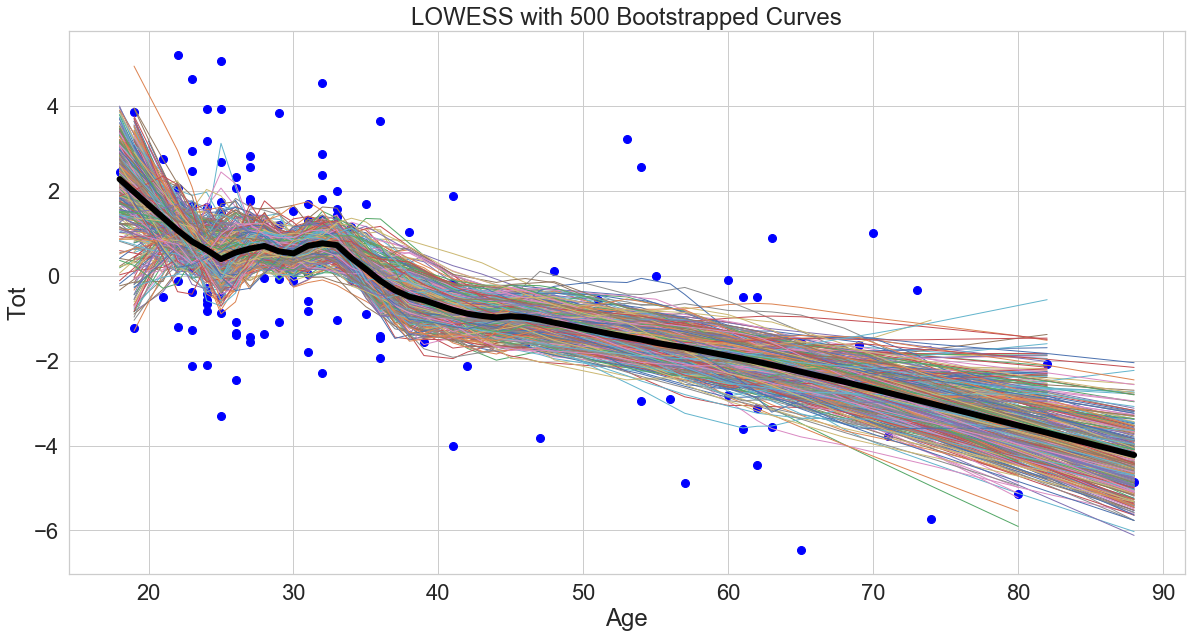

In [8]:
plt.plot(x, y, 'o', c='blue', ms=8)

for idx in range(B):
    tmp = boot[boot['nboot'] == idx]
    xb = tmp.age.values
    yb = tmp.tot.values
    plt.plot(xb, yb, '-', lw=1)
    
plt.plot(x, ypred, '-', c='black', lw=6)
plt.xlabel('Age')
plt.ylabel('Tot')
plt.title('LOWESS with {} Bootstrapped Curves'.format(B))
plt.show()

In [9]:
ages = pd.DataFrame({'age': [], 'lower': [], 'upper': []})
for a in [20, 30, 41, 51, 60, 70, 80]:
    tmp = boot[boot['age'] == a]
    
    vals = tmp.tot.values
    
    ql = np.nanquantile(vals, 0.025)
    qu = np.nanquantile(vals, 0.975)
    
    tmp = pd.DataFrame({'age': [a], 'lower': [ql], 'upper': [qu]})
    ages = pd.concat([ages, tmp], ignore_index=True)

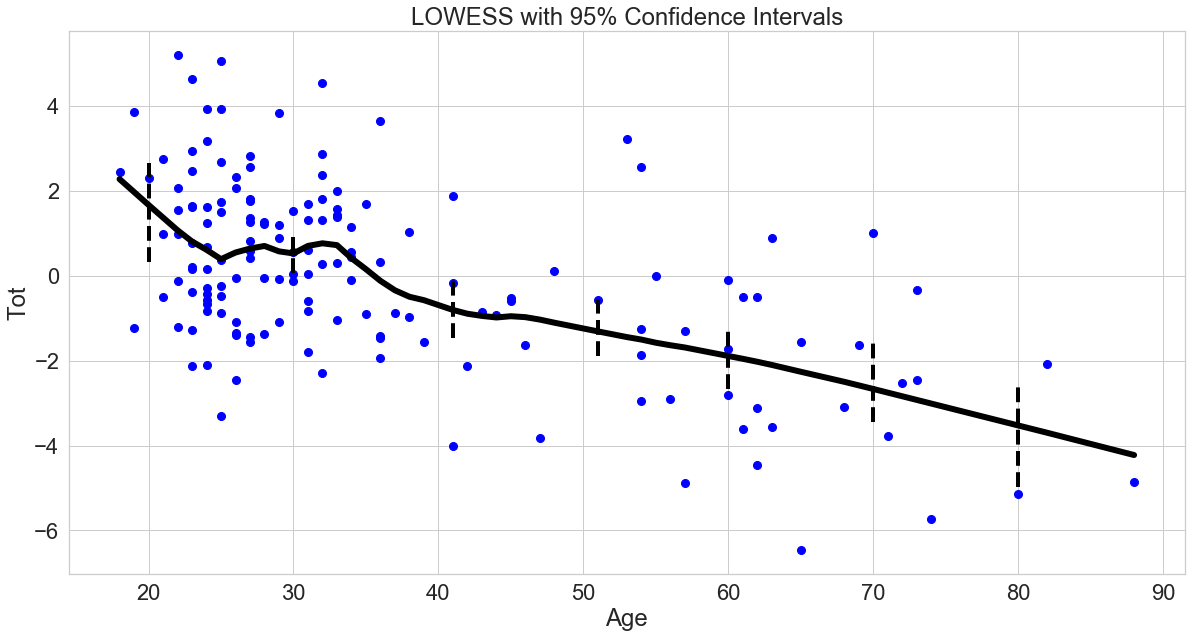

In [10]:
plt.plot(x, y, 'o', c='blue', ms=8)
        
for idx in range(ages.shape[0]):
    tmp = ages.iloc[idx]
    plt.plot([tmp.age, tmp.age], [tmp.lower, tmp.upper], 
             '--', c='black', lw=4)
    
plt.plot(x, ypred, '-', c='black', lw=6)
plt.xlabel('Age')
plt.ylabel('Tot')
plt.title('LOWESS with 95% Confidence Intervals')
plt.show()